In [399]:
import pandas as pd

df = pd.read_csv('indonesian-names.csv')

In [400]:
from collections import defaultdict

names = list(df['name'])
labels = list(df['gender'])

zip_list = list(zip(labels, names))

train_test_split = int(len(names) * 0.8)
train_names = list(names[:train_test_split])
train_labels = labels[:train_test_split]
test_names = names[train_test_split:]

label_dict = defaultdict(list)
for label, name in zip_list:
    label_dict[label].append(name)

In [401]:
# converting name lines into tensors
import torch
import string

vocab_size = len(names)

def name2Idx(name):
    return names.index(name)

def name2Tensor(name):
    tensor = torch.zeros(1, vocab_size)
    tensor[0][name2Idx(name)] = 1
    return tensor

name2Tensor('gustian').size()

torch.Size([1, 1960])

In [402]:
# create the feed-forward model
import torch
import torch.nn as nn

class FeedForward(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FeedForward, self).__init__()

        self.input2hidden = nn.Linear(input_size, hidden_size)
        self.hidden2out = nn.Linear(hidden_size, output_size)

    def forward(self, input):
        hidden = self.input2hidden(input)
        output = self.hidden2out(hidden)
        return output

In [403]:
# training helper functions
import random
import numpy as np
import torch.nn.functional as F

labels = ['m', 'f']

def chooseRandom(list):
    return list[random.randint(0, len(list) - 1)]

def trainingExample():
    label = chooseRandom(labels)
    name = chooseRandom(label_dict[label])
    label_tensor = torch.LongTensor([labels.index(label)])
    name_tensor = name2Tensor(name)
    return label, name, label_tensor, name_tensor

def get_label_from_output(output):
    probabilities = F.softmax(output, dim=1)
    
    _, predicted_index = torch.max(probabilities, 1)
 
    predicted_label = labels[predicted_index.item()]
    
    return predicted_label

In [404]:
# model trainer
def train(classifier, label_tensor, name_tensor, ce_loss, optimizer):
    optimizer.zero_grad()
    output = classifier(name_tensor)
    loss = ce_loss(output, label_tensor)
    loss.backward()
    optimizer.step()
    return output, loss.item()
    

In [423]:
from torch import nn, optim

classifier = FeedForward(vocab_size, 128, len(labels))
optimizer = optim.Adam(classifier.parameters())
ce_loss = nn.CrossEntropyLoss()

losses_total = []

def train_outputs(num_iter):
    current_loss = 0
    for iter in range(num_iter):
        label, name, label_tensor, name_tensor = trainingExample()
        output, loss = train(classifier, label_tensor, name_tensor, ce_loss, optimizer)
        current_loss += loss

        if iter % 1000 == 0:
            guess = get_label_from_output(output)
            correct = '✓' if guess == label else '✗ (%s)' % label
            print("%d %d%% %.4f %s / %s %s" % (iter, iter / num_iter * 100, loss, name, guess, correct))

        if iter % 1000 == 0:
            losses_total.append(current_loss / 1000)
            current_loss = 0


train_outputs(20000)


0 0% 0.7240 maniso / f ✗ (m)
1000 5% 0.1858 mustaqpirin / m ✓
2000 10% 0.0424 raditya alfarabi / m ✓
3000 15% 0.0205 muhammad asri wisnu wardana / m ✓
4000 20% 0.0025 diky handriansyah / m ✓
5000 25% 0.0022 muhammad asri wisnu wardana / m ✓
6000 30% 0.0014 wiji lestari / f ✓
7000 35% 0.0010 ade irmayani / f ✓
8000 40% 0.0005 fendi selistiawan / m ✓
9000 45% 0.0011 aila annafi'an zaini / f ✓
10000 50% 0.0103 sri lestari / f ✓
11000 55% 0.0187 istiani / f ✓
12000 60% 0.0000 ponirah / f ✓
13000 65% 0.0000 mu'alifah / f ✓
14000 70% 0.0098 sabrina fatmawati / f ✓
15000 75% 0.0000 gino / m ✓
16000 80% 0.0000 ninik sulastri / f ✓
17000 85% 0.0000 indah mawarni / f ✓
18000 90% 0.0000 mesinem / f ✓
19000 95% 0.0000 ngatini / f ✓


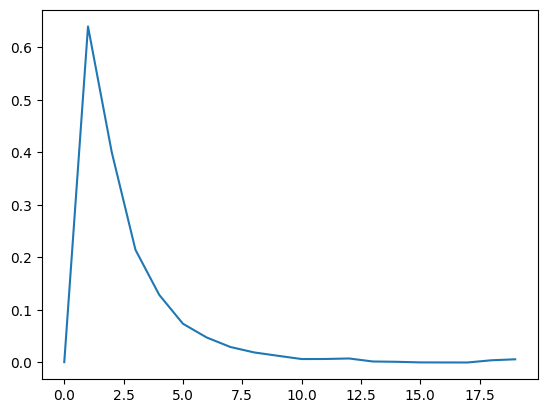

In [424]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(losses_total)